7.2.2021

### Image Processing in Physics

#### Julia Herzen, Klaus Achterhold, Clemens Schmid, Manuel Schultheiss

# Exercise 2: ART

Tomographic reconstruction with an algebraic reconstruction technique (ART)

In this exercise you will create your own implementation of ART
and do a reconstruction of the Shepp-Logan head phantom.

Functions for forward- and backprojection are provided for you.

- The sinogram is given in `phantom_sino256.npy`
- The phantom is given in `phantom_tomo256.npy`

For this exercise, we use two different initial guesses for the tomogram: Either 0's or the FBP.

As always, replace the `???`s with the correct commands.

In [1]:
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["image.cmap"] = "gray"
plt.rcParams["image.interpolation"] = "none"

We implemented the forward and backprojection for you:

In [2]:
def get_mask(shape):
    """
    Apply round mask with radius N on square array with dimensions (npix, npix).
    """
    xx, yy = np.meshgrid(np.linspace(-1, 1, shape[1], True), 
                         np.linspace(-1, 1, shape[0], True), indexing='ij')
    mask = (xx**2 + yy**2) <= 1.
    return mask


def forwardproject(sample, angles):
    """
    Simulate data aquisition in tomography from line projections.
    Forwardproject a given input sample slice to obtain a simulated sinogram.

    Hints
    -----
    Use scipy.ndimage.rotate(..., reshape=False) to simulate the sample
    rotation.
    Use numpy.sum() along one axis to simulate the line projection integral.
    """
    nproj = len(angles)  # Calculate number of projections
    sh = sample.shape  # Calculate shape of sample

    # Define empty sinogram container, angles along x-axis:
    sinogram = np.zeros([nproj, sh[1]], dtype=np.float32)

    # Loop over all projections:
    for i, ang in enumerate(angles):
        print("Simulating: %03i/%i" % (i + 1, nproj), end="\r", flush=True)
        
        im_rot = nd.rotate(sample, ang, reshape=False, order=1)
        sinogram[i] = np.sum(im_rot, axis=0)
    return sinogram


def filter_ramlak(sinogram):
    """
    Filter a given sinogram using a ramp filter

    Hints
    -----
    First define a ramp filter in Fourier domain (you can use np.fft.fftfreq).
    Filter the sinogram in Fourier space using the convolution theorem.
    """
    # Sinogram dimensions
    npix = sinogram.shape[1]

    # Generate basic ramp filter (hint: there is the function np.fft.fftfreq.
    # Try it and see what it does. Watch out for a possible fftshift)
    ramp_filter = np.pi * np.abs(np.fft.fftfreq(npix))

    # filter the sinogram in Fourier space in detector pixel direction
    # Use the np.fft.fft along the axis=1
    sino_ft = np.fft.fft(sinogram, axis=1)

    # Multiply the ramp filter onto the 1D-FT of the sinogram and transform it
    # back into spatial domain
    sino_filtered = np.real(np.fft.ifft(sino_ft * ramp_filter, axis=1))

    return sino_filtered


def backproject(sinogram, angles):
    """
    Backproject a given sinogram.
    Hints
    -----
    Perform the backprojection inversely to the way we did the
    forwardprojection, by smearing each projection in the sinogram back along
    the axis that you summed before in forwardproject(),
    then rotating the resulting backprojection
    to get the right backprojection angle.
    Use scipy.ndimage.rotate(..., ..., reshape=False)
    """
    # calculate number of projections, and pixels
    nproj, npix = sinogram.shape

    # define empty container for reconstruction of sample
    reconstruction = np.zeros([npix, npix], dtype=np.float32)

    # loop over all projections
    for i, ang in enumerate(angles):
        print("Reconstructing: %03i / %i" % (i + 1, nproj), end="\r", flush=True)

        backprojection = np.tile(sinogram[i], (npix, 1))
        backprojection /= nproj  # Just normalization

        rotated_backprojection = nd.rotate(
            backprojection, -ang, reshape=False, order=1)

        # Add the rotated backprojection
        reconstruction += rotated_backprojection

    reconstruction *= get_mask(reconstruction.shape)

    return reconstruction

## Task 1: Generate sinograms, perform FBP

First, we generate a filtered backprojection from the sinogram:

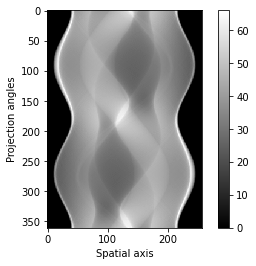

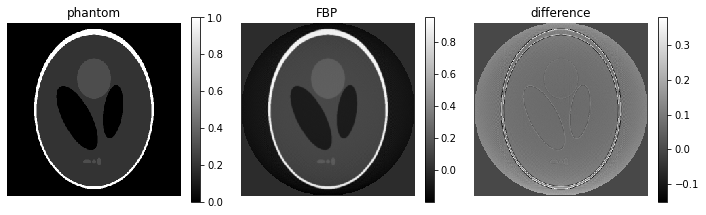

In [3]:
# Load the sinogram and extract dimensions
sinogram = np.load('phantom_sino256.npy')
nproj, npix = sinogram.shape

# Plot the sinogram
plt.figure()
plt.imshow(sinogram, cmap='gray')
plt.colorbar()
plt.xlabel('Spatial axis')
plt.ylabel('Projection angles')

# Create angles
angles = np.linspace(0, 360., nproj, False)

sino_filtered = filter_ramlak(sinogram)
fbp = backproject(sino_filtered, angles)

# Load the phantom. Your estimate tomogram should look something like this
phantom = np.load('phantom_tomo256.npy')

# Plot the phantom, FBP, and their difference.
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.title('phantom')
plt.imshow(phantom)
plt.colorbar()
plt.axis('off')
plt.subplot(132)
plt.title('FBP')
plt.imshow(fbp)
plt.colorbar()
plt.axis('off')
plt.subplot(133)
plt.title('difference')
plt.imshow(phantom - fbp)
plt.colorbar()
plt.axis('off')
plt.tight_layout()

## Task 2: Perform algebraic reconstruction (ART)

Next, we want to perform the reconstruction using the algebraic reconstruction technique (ART).
This is an iterative technique which involves the following steps:

* Make an initial guess for the tomogram.
* While not converged:
    1. Calculate the sinograms from the current guess for the tomogram
    2. Find the difference between the calculated sinograms and the measured tomograms.
    3. Backproject the difference over the tomogram slice
    4. Add this backprojected difference to the current guess for the tomogram.
    5. Repeat

Because this is an iterative technique, convergence speed depends on the initial guess for the tomogram.
To see this, you should calculate it twice, with different initial guesses:

* An array of zeroes
* The filtered backprojection

Naturally, the filtered backprojection is a much better guess, leaving much less work to do for the ART.

In [4]:
phantom.shape

(256, 256)

### Task 2a: Starting from zero(es)

Determine the number of iterations for yourself. How many are necessary to achieve a similar image quality as the filtered backprojection? (Hint: quite a lot!)

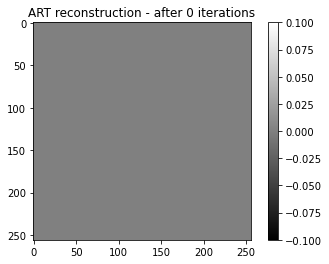

000 / 030,  Error = 1.17e+08


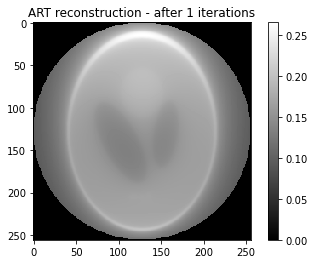

001 / 030,  Error = 8.54e+06


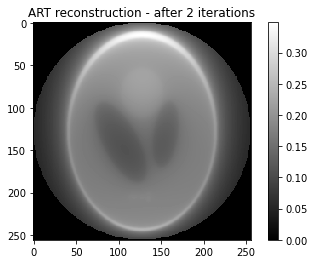

002 / 030,  Error = 6.13e+06


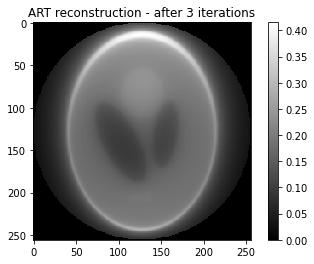

003 / 030,  Error = 4.71e+06


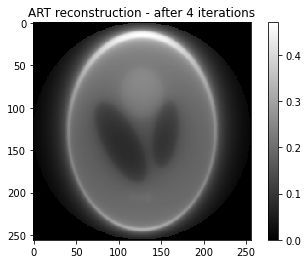

004 / 030,  Error = 3.79e+06


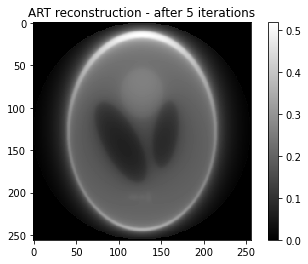

005 / 030,  Error = 3.15e+06


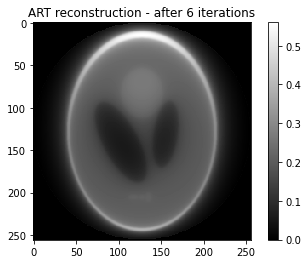

006 / 030,  Error = 2.68e+06


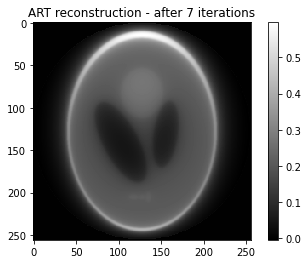

007 / 030,  Error = 2.32e+06


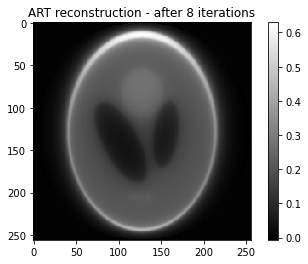

008 / 030,  Error = 2.03e+06


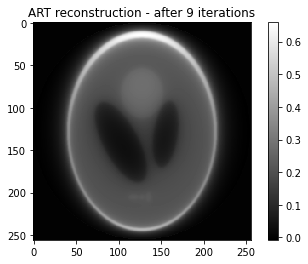

009 / 030,  Error = 1.80e+06


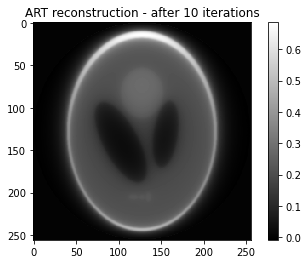

010 / 030,  Error = 1.61e+06


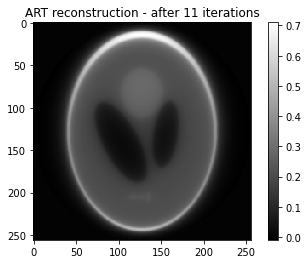

011 / 030,  Error = 1.45e+06


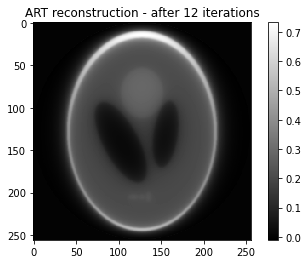

012 / 030,  Error = 1.32e+06


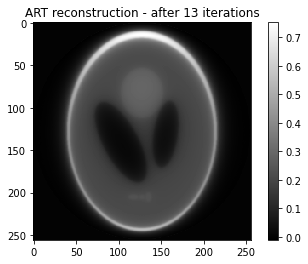

013 / 030,  Error = 1.20e+06


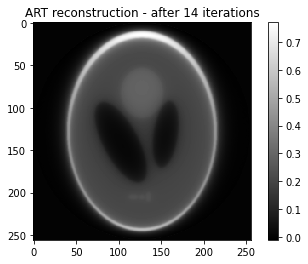

014 / 030,  Error = 1.10e+06


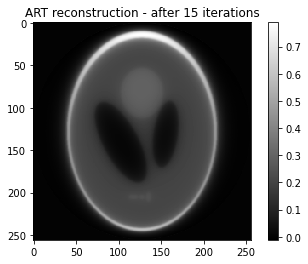

015 / 030,  Error = 1.01e+06


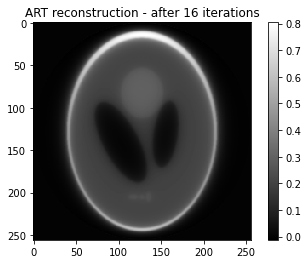

016 / 030,  Error = 9.35e+05


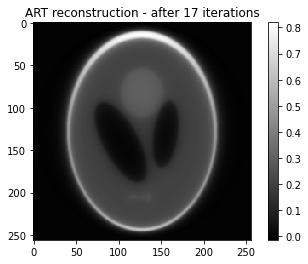

017 / 030,  Error = 8.66e+05


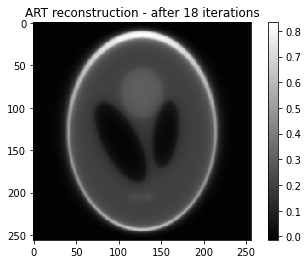

018 / 030,  Error = 8.04e+05


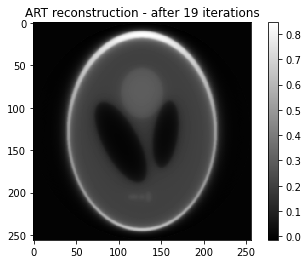

019 / 030,  Error = 7.49e+05


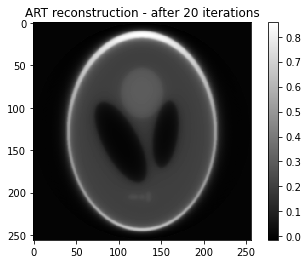

020 / 030,  Error = 7.00e+05


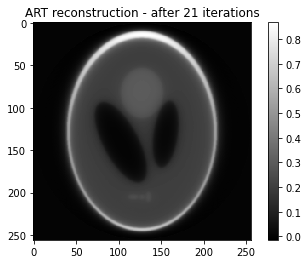

021 / 030,  Error = 6.55e+05


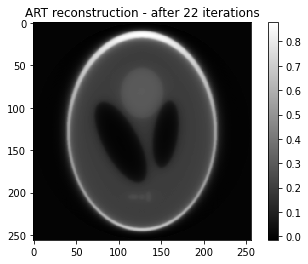

022 / 030,  Error = 6.14e+05


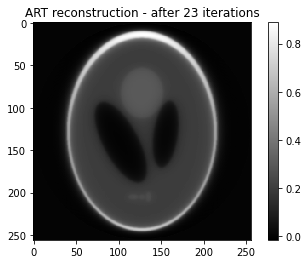

023 / 030,  Error = 5.77e+05


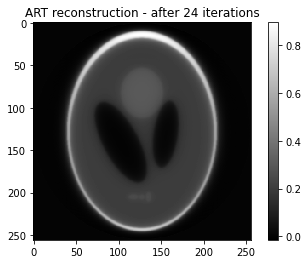

024 / 030,  Error = 5.43e+05


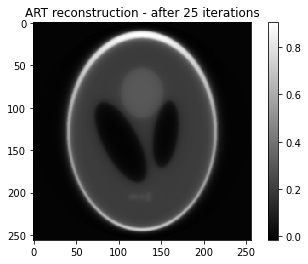

025 / 030,  Error = 5.12e+05


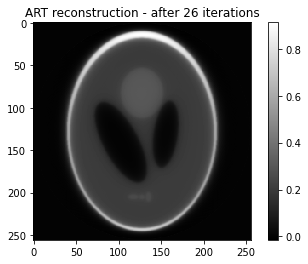

026 / 030,  Error = 4.83e+05


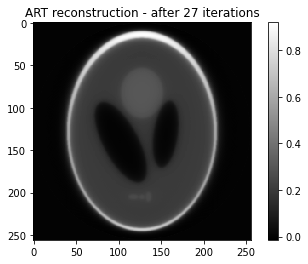

027 / 030,  Error = 4.57e+05


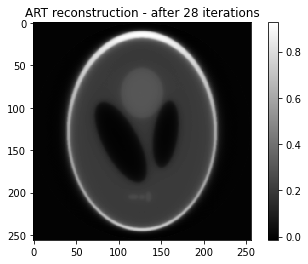

028 / 030,  Error = 4.33e+05


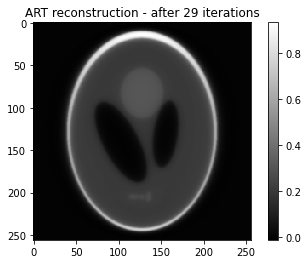

029 / 030,  Error = 4.10e+05


In [5]:
# The number of iterations for the ART algorithm    
iters = 20  

# Calculate the number of pixels and angles from the sinogram shape
nproj, npix = sinogram.shape

# Create nproj equally spaced theta values over the full 360 degrees
# (Don't include 0°=360° twice!)
angles = np.linspace(0,360, nproj, False)

# Prepare mask and renormalization term 
# (Technical detail, don't worry about this too much)
mask = get_mask(phantom.shape)

# The number of image pixels contributing to the respective ray 
# (In parallel beam, same for all angles)
mask_proj = np.sum(mask, axis=0)

# Norm is 1/#image pixels. This accounts for division by 0.
renorm = np.zeros(npix, dtype=np.float32)
renorm[mask_proj != 0] = 1. / mask_proj[mask_proj != 0]

# Start with an initial guess of zeros for the tomogram
initial_tomo = np.zeros([npix, npix], dtype=np.float32)

# Initialize
tomo = initial_tomo.copy()
error = []

# Main loop over the iterations:
for i in range(iters):
    plt.figure()
    plt.imshow(tomo)
    plt.colorbar()
    plt.title('ART reconstruction - after %i iterations' % i)
    plt.pause(0.01)  # update figure

    # Forwardproject your tomogram for the current angle:
    proj = forwardproject(tomo, angles)
            
    # Calculate the difference between the forward projection and 
    # the sinogram for the current angle:    
    diff = sinogram - proj
        
    # Accumulate the error to the total error
    error.append(np.sum(diff**2))
        
    # Back-project the renormalized difference for the current angle.
    # Hint: Multiply the difference by renorm calculated above!
    tomo_update = backproject(renorm*diff, angles)
        
    # Update the tomogram
    tomo += tomo_update
    
    print("\r%03i / %03i,  Error = %.2e" % (i, iters, error[-1]))

Plot the error of the estimated sinograms, the reconstructions, and line plots through the sinograms:

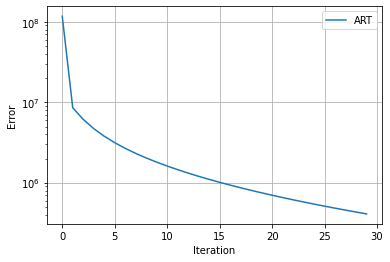

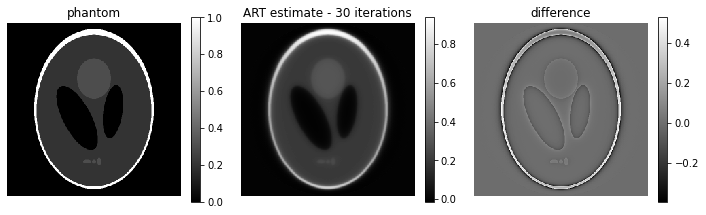

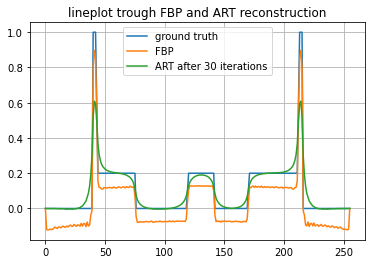

In [6]:
# Plot the error versus the number of iterations.
plt.figure()
plt.semilogy(error, label='ART')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.grid(True)
plt.legend()

# Plot your estimate of the tomogram as above for the FBP
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.title('phantom')
plt.imshow(phantom)
plt.colorbar()
plt.axis('off')
plt.subplot(132)
plt.title('ART estimate - %i iterations' % iters)
plt.imshow(tomo)
plt.colorbar()
plt.axis('off')
plt.subplot(133)
plt.title('difference')
plt.imshow(phantom - tomo)
plt.colorbar()
plt.axis('off')
plt.tight_layout()

# Prepare a lineplot through the FBP and ART reconstruction and compare it to
# the loaded phantom. 
plt.figure()
plt.title('lineplot trough FBP and ART reconstruction')
plt.plot(phantom[npix//2], label='ground truth')
plt.plot(fbp[npix//2], label='FBP')
plt.plot(tomo[npix//2], label='ART after %i iterations' % iters)
plt.grid(True)
plt.legend()

## 2b: Starting from FBP

Please copy below the code block for the ART calculation in 2a, and use the filtered backprojection as the initial guess for the tomogram.

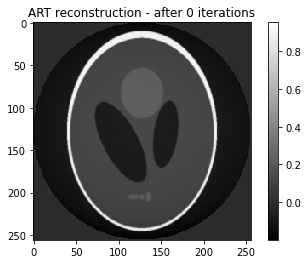

000 / 020,  Error = 3.62e+07


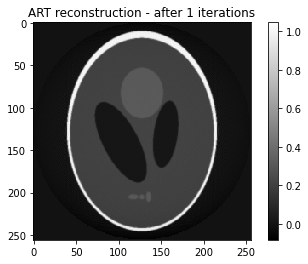

001 / 020,  Error = 1.75e+05


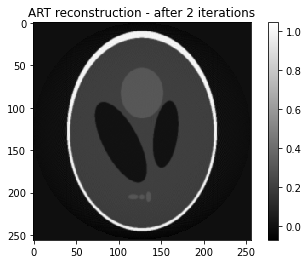

002 / 020,  Error = 8.15e+04


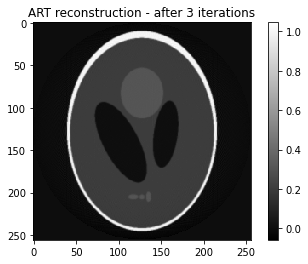

003 / 020,  Error = 4.08e+04


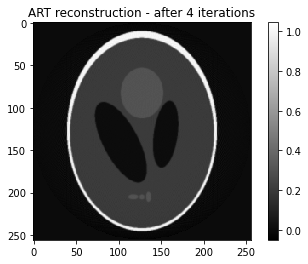

004 / 020,  Error = 2.29e+04


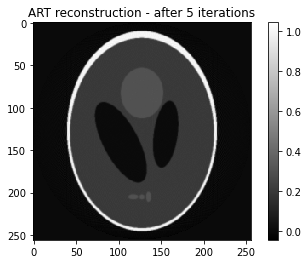

005 / 020,  Error = 1.49e+04


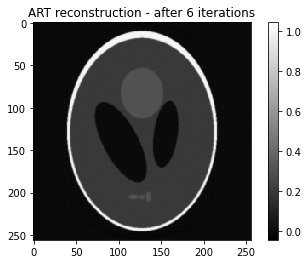

006 / 020,  Error = 1.13e+04


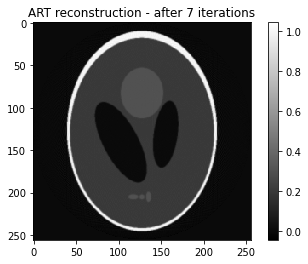

007 / 020,  Error = 9.58e+03


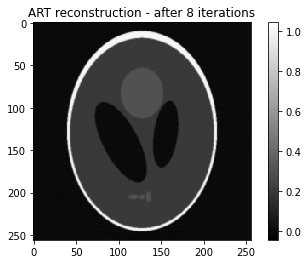

008 / 020,  Error = 8.70e+03


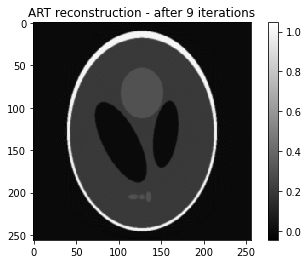

009 / 020,  Error = 8.21e+03


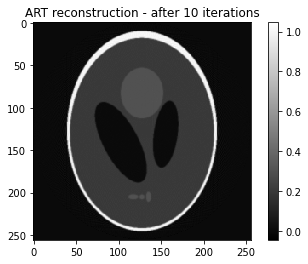

010 / 020,  Error = 7.89e+03


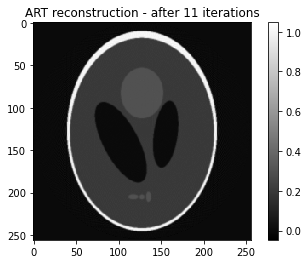

011 / 020,  Error = 7.66e+03


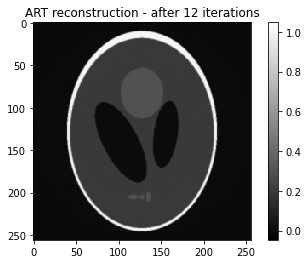

012 / 020,  Error = 7.47e+03


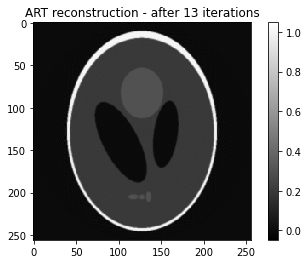

013 / 020,  Error = 7.31e+03


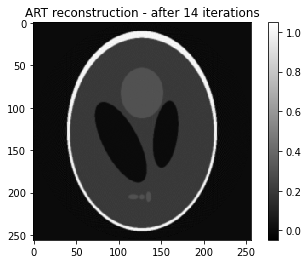

014 / 020,  Error = 7.16e+03


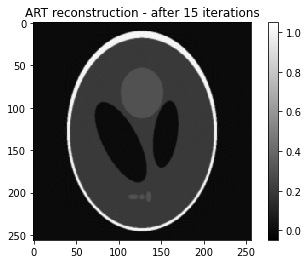

015 / 020,  Error = 7.03e+03


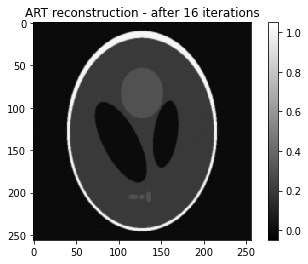

016 / 020,  Error = 6.90e+03


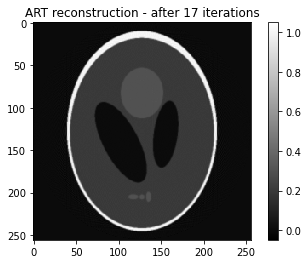

017 / 020,  Error = 6.78e+03


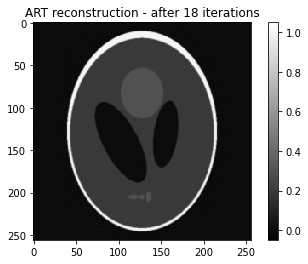

018 / 020,  Error = 6.66e+03


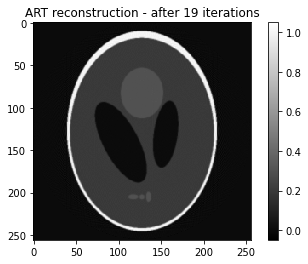

019 / 020,  Error = 6.55e+03


In [7]:
# code here...#
# The number of iterations for the ART algorithm    
iters = 20  

# Calculate the number of pixels and angles from the sinogram shape
nproj, npix = sinogram.shape

# Create nproj equally spaced theta values over the full 360 degrees
# (Don't include 0°=360° twice!)
angles = np.linspace(0,360, nproj, False)


# Prepare mask and renormalization term 
# (Technical detail, don't worry about this too much)
mask = get_mask(phantom.shape)

# The number of image pixels contributing to the respective ray 
# (In parallel beam, same for all angles)
mask_proj = np.sum(mask, axis=0)

# Norm is 1/#image pixels. This accounts for division by 0.
renorm = np.zeros(npix, dtype=np.float32)
renorm[mask_proj != 0] = 1. / mask_proj[mask_proj != 0]

# Start with an initial guess of zeros for the tomogram
initial_tomo = fbp.copy

# Initialize
tomo = initial_tomo.copy()
error = []

# Main loop over the iterations:
for i in range(iters):
    plt.figure()
    plt.imshow(tomo)
    plt.colorbar()
    plt.title('ART reconstruction - after %i iterations' % i)
    plt.pause(0.01)  # update figure

    # Forwardproject your tomogram for the current angle:
    proj = forwardproject(tomo, angles)
            
    # Calculate the difference between the forward projection and 
    # the sinogram for the current angle:    
    diff = sinogram - proj
        
    # Accumulate the error to the total error
    error.append(np.sum(diff**2))
        
    # Back-project the renormalized difference for the current angle.
    # Hint: Multiply the difference by renorm calculated above!
    tomo_update = backproject(renorm*diff, angles)
        
    # Update the tomogram
    tomo += tomo_update
    
    print("\r%03i / %03i,  Error = %.2e" % (i, iters, error[-1]))

Copy the code block with the result plots below:

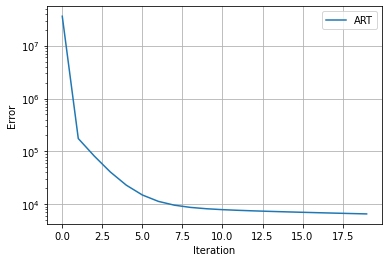

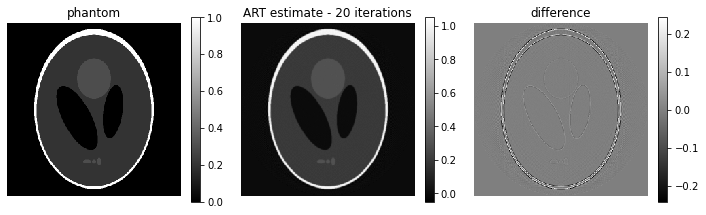

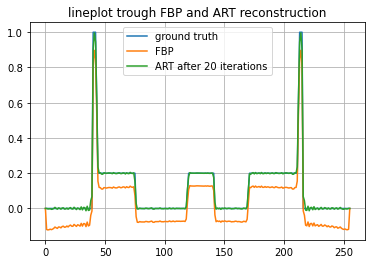

In [8]:
# code here...#

# Plot the error versus the number of iterations.
plt.figure()
plt.semilogy(error, label='ART')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.grid(True)
plt.legend()

# Plot your estimate of the tomogram as above for the FBP
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.title('phantom')
plt.imshow(phantom)
plt.colorbar()
plt.axis('off')
plt.subplot(132)
plt.title('ART estimate - %i iterations' % iters)
plt.imshow(tomo)
plt.colorbar()
plt.axis('off')
plt.subplot(133)
plt.title('difference')
plt.imshow(phantom - tomo)
plt.colorbar()
plt.axis('off')
plt.tight_layout()

# Prepare a lineplot through the FBP and ART reconstruction and compare it to
# the loaded phantom. 
plt.figure()
plt.title('lineplot trough FBP and ART reconstruction')
plt.plot(phantom[npix//2], label='ground truth')
plt.plot(fbp[npix//2], label='FBP')
plt.plot(tomo[npix//2], label='ART after %i iterations' % iters)
plt.grid(True)
plt.legend()